In [13]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from math import pi
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


## Importação de Dados do Big Query

### Autenticação

In [14]:
#Importando Dados do Big Query
from google.cloud import bigquery
from google.api_core import exceptions

key_path = "keyfile.json"

try:
    client = bigquery.Client.from_service_account_json(key_path)

    print(f"Autenticação bem-sucedida com o projeto: {client.project}")

except FileNotFoundError:
    print(f"ERRO: O arquivo de chave não foi encontrado no caminho especificado: {key_path}")
    print("Verifique se o caminho está correto.")
    exit()
except Exception as e:
    print(f"Ocorreu um erro inesperado durante a autenticação: {e}")
    exit()


Autenticação bem-sucedida com o projeto: viitra-redu


### Consulta

In [19]:
data_inicio = '2020-01-01'
data_fim = '2021-12-31'
nivel_hierarquia = ['ENV', 'CRS', 'SPA']

# 1. Inicie um dicionário vazio para armazenar os DataFrames
dataframes = {}

for nivel in nivel_hierarquia:
    print(f"Executando consulta para o nível: {nivel}...")
    
    sql_query = f"""
    select
        eng.cliente
        ,eng.user_id
        ,eng.environment_id
        ,eng.course_id
        ,eng.space_id
        ,eng.subject_id
        ,eng.lecture_id
        ,eng.NivelAgregacao
        ,eng.user_name
        ,eng.environment_name
        ,eng.course_name
        ,eng.space_name
        ,eng.subject_name
        ,eng.lecture_name
        ,eng.period_start_date
        ,eng.period_end_date
        ,eng.postsAmount
        ,eng.postRepliesAmount
        ,eng.helpRequestsAmount
        ,eng.helpRequestRepliesAmount
        ,eng.performance_rate
    from analytics.fn_engajamento(
    DATE('{data_inicio}'),
    DATE('{data_fim}'),
    TRUE,'redu-digital',
    NULL,
    NULL,
    NULL,
    NULL,
    NULL, '{nivel}', 'QUARTER' 
    ) as eng
    inner join (
        select 
            uea.user_id
            ,uea.cliente 
        from replicas.user_environment_associations uea 
        where uea.role not in ('teacher', 'tutor', 'environment_admin')
    ) as filtro on filtro.cliente = eng.cliente and filtro.user_id = eng.user_id
    """
    
    try:
        dataframe_resultado = client.query(sql_query).to_dataframe()
        
        dataframes[nivel] = dataframe_resultado
        
        print(f"DataFrame para o nível '{nivel}' criado com sucesso e armazenado.")
        # print(dataframes_por_nivel[nivel].head())
        
    except exceptions.Forbidden as e: 
        print(f"ERRO DE PERMISSÃO para o nível {nivel}: {e}")
        print("A autenticação funcionou, mas a conta de serviço não tem permissão para acessar os dados.")
        print("Verifique os papéis de IAM (ex: 'BigQuery User') no Google Cloud Console.")
    except Exception as e:
        print(f"Ocorreu um erro inesperado para o nível {nivel}: {e}")

print("\nProcesso finalizado! Todos os DataFrames foram criados.")

Executando consulta para o nível: ENV...
DataFrame para o nível 'ENV' criado com sucesso e armazenado.
Executando consulta para o nível: CRS...
DataFrame para o nível 'CRS' criado com sucesso e armazenado.
Executando consulta para o nível: SPA...
DataFrame para o nível 'SPA' criado com sucesso e armazenado.

Processo finalizado! Todos os DataFrames foram criados.


In [20]:
# Verificando as chaves (níveis) que foram armazenadas no dicionário
print("\nNíveis de hierarquia armazenados no dicionário:")
print(list(dataframes.keys()))

for nivel in nivel_hierarquia:
    print(dataframes[nivel].head())
    dataframes[nivel].info()
    


Níveis de hierarquia armazenados no dicionário:
['ENV', 'CRS', 'SPA']
        cliente  user_id  environment_id  course_id  space_id  subject_id  \
0  redu-digital    11049             600       <NA>      <NA>        <NA>   
1  redu-digital    11049             600       <NA>      <NA>        <NA>   
2  redu-digital    11049             600       <NA>      <NA>        <NA>   
3  redu-digital    11049             600       <NA>      <NA>        <NA>   
4  redu-digital    11049             600       <NA>      <NA>        <NA>   

   lecture_id NivelAgregacao   user_name       environment_name  ...  \
0        <NA>            ENV  Maria Rita  Corporativo Advocacia  ...   
1        <NA>            ENV  Maria Rita  Corporativo Advocacia  ...   
2        <NA>            ENV  Maria Rita  Corporativo Advocacia  ...   
3        <NA>            ENV  Maria Rita  Corporativo Advocacia  ...   
4        <NA>            ENV  Maria Rita  Corporativo Advocacia  ...   

  space_name subject_name lecture

## Análise Exploratória

In [25]:
# for nivel in nivel_hierarquia:
dataframes['ENV'].describe()

,user_id,environment_id,course_id,space_id,subject_id,lecture_id,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
count,126688.0,126688.0,0.0,0.0,0.0,0.0,126688.0,126688.0,126688.0,126688.0,73048.000000
mean,9237.569336,206.272859,<NA>,<NA>,<NA>,<NA>,0.151064,0.016742,0.001145,0.001034,0.007225
std,5614.758421,149.678043,<NA>,<NA>,<NA>,<NA>,1.82339,0.949952,0.04021,0.045896,0.056716
min,2.0,7.0,<NA>,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
25%,4969.75,88.0,<NA>,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
50%,9083.5,180.0,<NA>,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
75%,13525.25,259.0,<NA>,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
max,19270.0,736.0,<NA>,<NA>,<NA>,<NA>,193.0,206.0,4.0,6.0,1.000000


In [27]:
dataframes['CRS'].describe()

,user_id,environment_id,course_id,space_id,subject_id,lecture_id,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
count,267952.0,267952.0,267952.0,0.0,0.0,0.0,267952.0,267952.0,267952.0,267952.0,178448.000000
mean,7439.957574,181.274527,512.095898,<NA>,<NA>,<NA>,0.071423,0.007916,0.000541,0.000489,0.009517
std,5696.161282,144.467781,420.583557,<NA>,<NA>,<NA>,1.141077,0.648422,0.027655,0.031086,0.090825
min,2.0,7.0,11.0,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
25%,2216.0,88.0,198.0,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
50%,5478.5,88.0,395.0,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
75%,11985.0,242.0,606.0,<NA>,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
max,19270.0,736.0,1664.0,<NA>,<NA>,<NA>,80.0,206.0,4.0,6.0,1.000000


In [28]:
dataframes['SPA'].describe()

,user_id,environment_id,course_id,space_id,subject_id,lecture_id,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate
count,1181832.0,1181832.0,1181832.0,1181832.0,0.0,0.0,1181832.0,1181832.0,1181832.0,1181832.0,266968.000000
mean,6514.890035,170.694109,438.582458,984.838089,<NA>,<NA>,0.016194,0.001795,0.000123,0.000111,0.009674
std,4818.958313,129.58029,335.27378,1565.948525,<NA>,<NA>,0.3827,0.22395,0.012511,0.014041,0.092431
min,2.0,7.0,11.0,15.0,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
25%,2200.0,88.0,198.0,384.0,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
50%,4577.0,88.0,391.0,538.0,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
75%,10068.0,242.0,544.0,918.0,<NA>,<NA>,0.0,0.0,0.0,0.0,0.000000
max,19270.0,736.0,1664.0,8032.0,<NA>,<NA>,68.0,134.0,4.0,4.0,1.000000


In [34]:
datasets = dataframes
print(list(dataframes.keys()))

for nivel in nivel_hierarquia:
    datasets[nivel] = datasets[nivel].iloc[:, 16:]

['ENV', 'CRS', 'SPA']


In [35]:
for nivel in nivel_hierarquia:
    datasets[nivel].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126688 entries, 0 to 126687
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   postsAmount               126688 non-null  Int64  
 1   postRepliesAmount         126688 non-null  Int64  
 2   helpRequestsAmount        126688 non-null  Int64  
 3   helpRequestRepliesAmount  126688 non-null  Int64  
 4   performance_rate          73048 non-null   float64
dtypes: Int64(4), float64(1)
memory usage: 5.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267952 entries, 0 to 267951
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   postsAmount               267952 non-null  Int64  
 1   postRepliesAmount         267952 non-null  Int64  
 2   helpRequestsAmount        267952 non-null  Int64  
 3   helpRequestRepliesAmount  267952 non-null  Int64  
 4

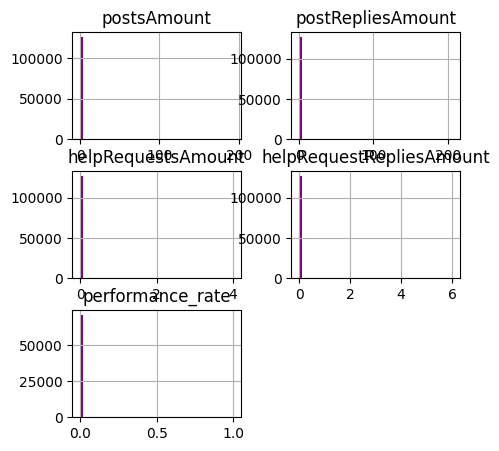

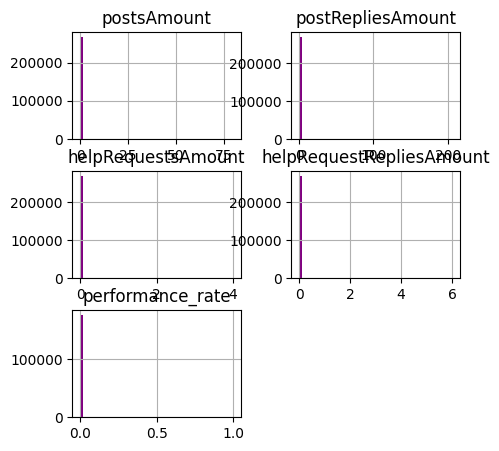

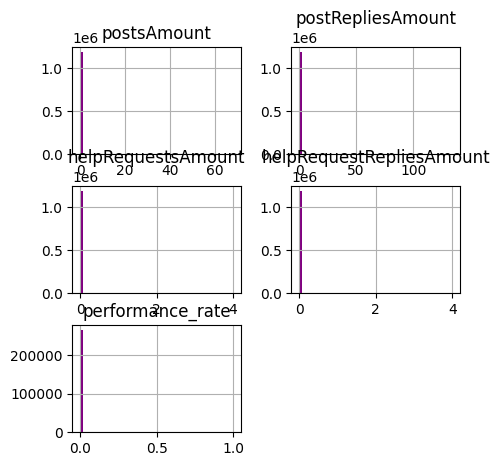

In [36]:
for nivel in nivel_hierarquia:
    datasets[nivel].hist(bins=50, figsize=(5, 5), color='purple')
    plt.show()

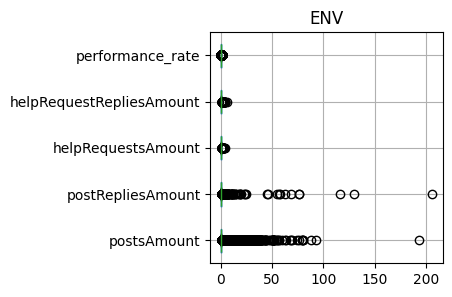

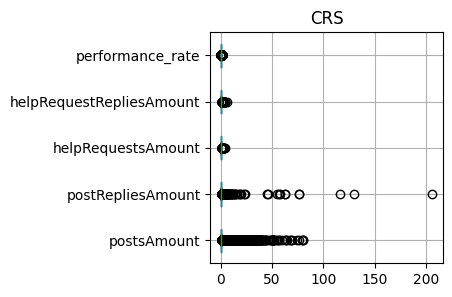

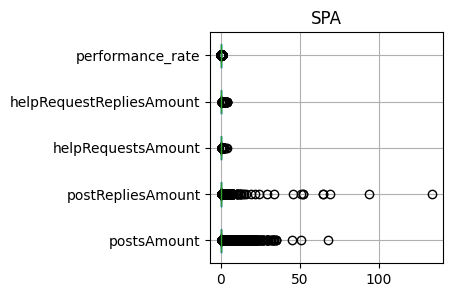

In [39]:
for nivel in nivel_hierarquia:
    datasets[nivel].boxplot(vert=False, figsize=(3, 3))
    plt.title(nivel)
    plt.show()

### Pré-Processamento

In [45]:
train_sets = datasets

for nivel in nivel_hierarquia:
    print(nivel)
    print(train_sets[nivel].shape)
    print('\n')

ENV
(126688, 5)


CRS
(267952, 5)


SPA
(1181832, 5)




#### Tratando Valores Faltantes

In [67]:
imputers = {}
for nivel in nivel_hierarquia:
    inputer = KNNImputer(n_neighbors=5)
    imputers[nivel] = inputer.fit(train_sets[nivel])

In [68]:
train_set_inpute = {}
for nivel in nivel_hierarquia:
    inputer = KNNImputer(n_neighbors=5)
    train_set_inpute[nivel] = imputers[nivel].transform(train_sets[nivel])

In [69]:
train_set_inpute['ENV'] = imputers['ENV'].transform(train_sets['ENV'])

In [70]:
train_set_inpute['CRS'] = imputers['CRS'].transform(train_sets['CRS'])

In [14]:
# train_set_inpute = inputer.transform(train_set)

In [73]:
# nivel_hierarquia.remove('SPA')

train_set_inputado = {}



for nivel in nivel_hierarquia:
    train_set_inputado[nivel] = pd.DataFrame(
        train_set_inpute[nivel],
        columns=train_sets[nivel].columns,
        index=train_sets[nivel].index
    )
    train_sets[nivel] = train_set_inputado[nivel].copy()
    train_sets[nivel].info()
    train_sets[nivel].describe()
    print(train_sets[nivel].columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126688 entries, 0 to 126687
Data columns (total 10 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   postsAmount                   126688 non-null  float64
 1   postRepliesAmount             126688 non-null  float64
 2   helpRequestsAmount            126688 non-null  float64
 3   helpRequestRepliesAmount      126688 non-null  float64
 4   performance_rate              126688 non-null  float64
 5   postsAmount_log               126688 non-null  float64
 6   postRepliesAmount_log         126688 non-null  float64
 7   helpRequestsAmount_log        126688 non-null  float64
 8   helpRequestRepliesAmount_log  126688 non-null  float64
 9   performance_rate_log          126688 non-null  float64
dtypes: float64(10)
memory usage: 9.7 MB
Index(['postsAmount', 'postRepliesAmount', 'helpRequestsAmount',
       'helpRequestRepliesAmount', 'performance_rate', 'postsAm

In [16]:
# train_set = train_set_inputado.copy()
# train_set.info()

In [17]:
# train_set.describe()

In [18]:
# print(train_set.columns)

#### Tratando Outliers

In [74]:
df_features = train_sets
# Lista de colunas assimétricas
colunas_para_log = ['postsAmount', 'postRepliesAmount', 'helpRequestsAmount', 'helpRequestRepliesAmount', 'performance_rate'] # Exemplo

for nivel in nivel_hierarquia:
    for col in colunas_para_log:
    # nova coluna para não sobrescrever a original
        df_features[nivel][f'{col}_log'] = np.log1p(train_sets[nivel][col])

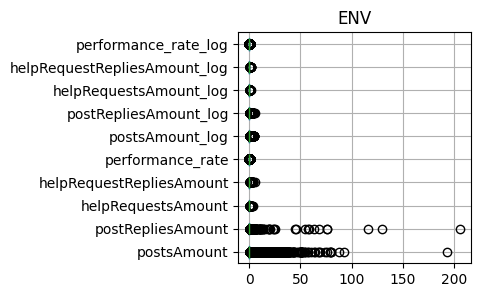

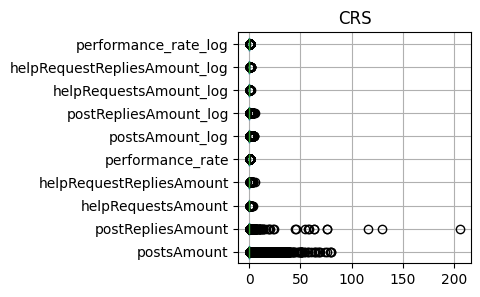

In [75]:
for nivel in nivel_hierarquia:
    df_features[nivel].boxplot(vert=False, figsize= (3,3))
    plt.title(nivel)
    plt.show()

In [76]:
train_sets_final = {}

for nivel in nivel_hierarquia:
    # Encontrar todas as colunas que terminam com '_log'
    log_cols = [col for col in df_features[nivel].columns if col.endswith('_log')]

    # A partir das colunas de log, deduzir os nomes das colunas originais que as geraram
    original_cols_to_drop = [col.replace('_log', '') for col in log_cols]

    # A lista final de colunas é composta por TODAS as colunas, EXCETO as originais que foram transformadas
    final_cols_to_keep = [col for col in df_features[nivel].columns if col not in original_cols_to_drop]


    # --- Passo 2: Criar o DataFrame Final ---
    train_sets_final[nivel] = df_features[nivel][final_cols_to_keep]
    train_sets_final[nivel].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126688 entries, 0 to 126687
Data columns (total 5 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   postsAmount_log               126688 non-null  float64
 1   postRepliesAmount_log         126688 non-null  float64
 2   helpRequestsAmount_log        126688 non-null  float64
 3   helpRequestRepliesAmount_log  126688 non-null  float64
 4   performance_rate_log          126688 non-null  float64
dtypes: float64(5)
memory usage: 4.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267952 entries, 0 to 267951
Data columns (total 5 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   postsAmount_log               267952 non-null  float64
 1   postRepliesAmount_log         267952 non-null  float64
 2   helpRequestsAmount_log        267952 non-null  float64
 3   helpRequestRepl

In [22]:
# train_set_final.info()

#### Escalonamento das Features

In [77]:
#feature_range=(-1, 1)
scalers = {}
for nivel in nivel_hierarquia:
    scaler = MinMaxScaler()
    scalers[nivel] =  scaler.fit(train_sets_final[nivel])
    

In [78]:
train_set_scaled_np = {}
for nivel in nivel_hierarquia:
    train_set_scaled_np[nivel] =  scalers[nivel].transform(train_sets_final[nivel])

In [79]:
train_sets_scaled = {}
for nivel in nivel_hierarquia:
    train_sets_scaled[nivel] = pd.DataFrame(
    train_set_scaled_np[nivel],
        columns=train_sets_final[nivel].columns,
        index=train_sets_final[nivel].index
    )

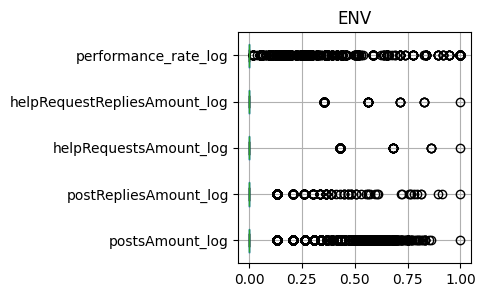

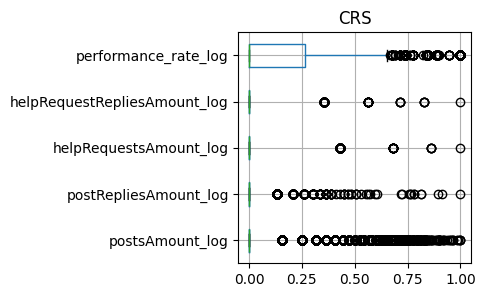

In [80]:
train_sets_final = {}
for nivel in nivel_hierarquia:
    train_sets_final[nivel] = train_sets_scaled[nivel].copy()
    train_sets_final[nivel].boxplot(vert=False, figsize= (3,3))
    plt.title(nivel)
    plt.show()

In [26]:
# train_set_final.boxplot(vert=False)
# plt.show()

## Treinamento Não-Supervisionado

#### Encontrando melhores parâmetros para o Kmeans

In [27]:
# faixas de k para testar
k_range = range(2, 11)  # começa em 2 (não faz sentido silhouette com k=1)

# métricas
wcss = []
silhouette = []
calinski = []
davies = []
bic = []

for k in k_range:
    # KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(train_set_final)

    wcss.append(kmeans.inertia_)
    silhouette.append(silhouette_score(train_set_final, labels))
    calinski.append(calinski_harabasz_score(train_set_final, labels))
    davies.append(davies_bouldin_score(train_set_final, labels))

    # BIC com GaussianMixture
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(train_set_final)
    bic.append(gmm.bic(train_set_final))

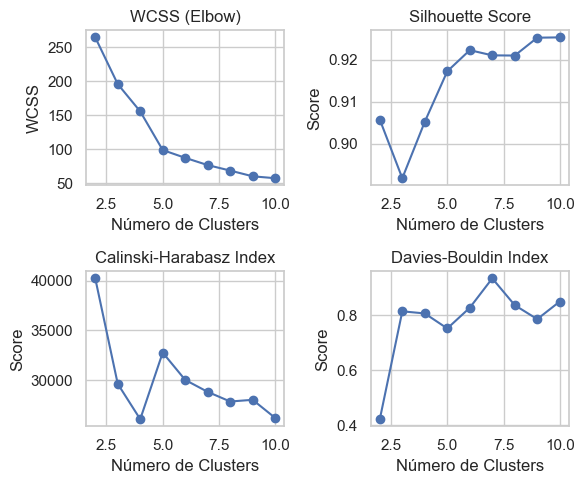

In [28]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 5))

# WCSS (cotovelo)
plt.subplot(2, 2, 1)
plt.plot(k_range, wcss, marker='o')
plt.title('WCSS (Elbow)')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')

# Silhouette
plt.subplot(2, 2, 2)
plt.plot(k_range, silhouette, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

# Calinski-Harabasz
plt.subplot(2, 2, 3)
plt.plot(k_range, calinski, marker='o')
plt.title('Calinski-Harabasz Index')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

# Davies-Bouldin (quanto menor, melhor)
plt.subplot(2, 2, 4)
plt.plot(k_range, davies, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# BIC separado (opcional)
# plt.figure()
# plt.plot(k_range, bic, marker='o')
# plt.title('BIC - Gaussian Mixture')
# plt.xlabel('Número de Clusters')
# plt.ylabel('BIC')
# plt.show()


#### Treinamento 

In [82]:
modelos = {}
for nivel in nivel_hierarquia:    
# Treinamento do K-Means
    kmeans = KMeans(n_clusters=4)
    modelos[nivel] = kmeans.fit(train_sets_final[nivel])
    # y_kmeans = kmeans.fit_predict(train_set_final[nivel])

In [83]:
y_kmeans = {}
for nivel in nivel_hierarquia:
    y_kmeans[nivel] = modelos[nivel].predict(train_sets_final[nivel])

In [86]:
tabelas_contagem = {}

for nivel in nivel_hierarquia:
    tabelas_contagem[nivel] = pd.Series(y_kmeans[nivel]).value_counts()
    # Exibe a tabela final
    print("Quantidade de itens por cluster em " + nivel)
    print(tabelas_contagem[nivel])

Quantidade de itens por cluster em ENV
0    124049
1      1334
3      1067
2       238
Name: count, dtype: int64
Quantidade de itens por cluster em CRS
0    175453
1     89933
2      1615
3       951
Name: count, dtype: int64


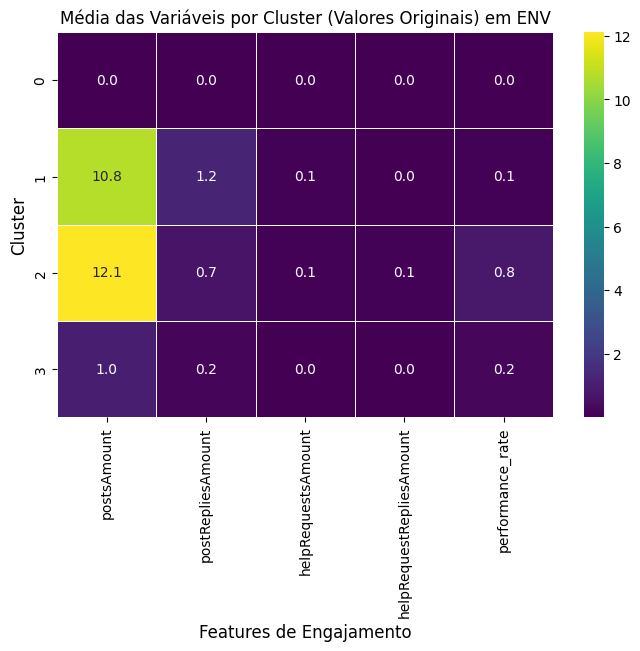

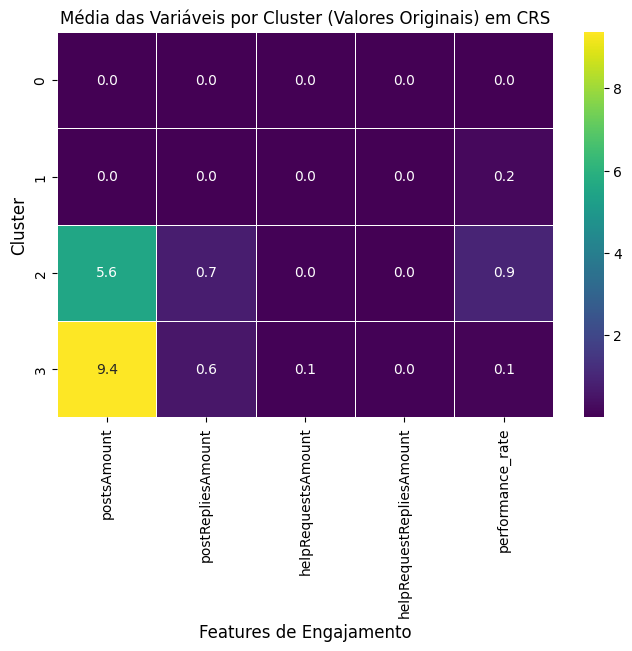

In [92]:
for nivel in nivel_hierarquia:
    df_features[nivel]['cluster'] = y_kmeans[nivel]

    # Calcular as médias por cluster
    #cluster_means = df_features[nivel].groupby('cluster').mean()
    cluster_means = df_features[nivel][[c for c in df_features[nivel].columns if not c.endswith('_log')]].groupby('cluster').mean()
    # Renomear colunas para o plot (removendo o sufixo '_log')
    #cluster_means_para_plotar = cluster_means.rename(columns=lambda c: c.replace('_log', ''))

    # Passo 3: Plotar o Heatmap
    plt.figure(figsize=(8, 5))
    sns.heatmap(
        cluster_means,
        annot=True,
        fmt='.1f',
        cmap='viridis',
        linewidths=.5
    )
    plt.title('Média das Variáveis por Cluster (Valores Originais) em ' + nivel, fontsize=12)
    plt.ylabel('Cluster', fontsize=12)
    plt.xlabel('Features de Engajamento', fontsize=12)
    plt.show()

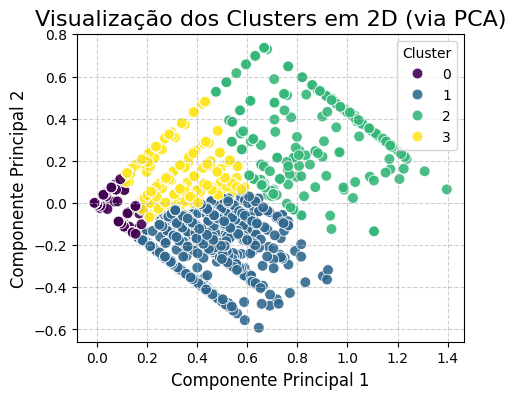

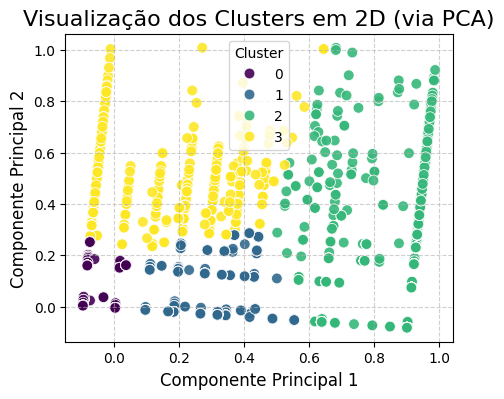

In [94]:
for nivel in nivel_hierarquia:   
 # Passo 1: Reduzir a dimensionalidade dos dados ESCALONADOS para 2D com PCA
    pca = PCA(n_components=2)
    dados_pca = pca.fit_transform(train_sets_final[nivel])

    # Passo 2: Criar um DataFrame para a visualização
    df_pca = pd.DataFrame({
        'PCA1': dados_pca[:, 0],
        'PCA2': dados_pca[:, 1],
        'Cluster': y_kmeans[nivel]
    })

    # Passo 3: Plotar o gráfico de dispersão
    plt.figure(figsize=(5, 4))
    sns.scatterplot(
        data=df_pca,
        x='PCA1',
        y='PCA2',
        hue='Cluster',
        palette='viridis',
        s=60,
        alpha=0.9
    )

    plt.title('Visualização dos Clusters em 2D (via PCA)', fontsize=16)
    plt.xlabel('Componente Principal 1', fontsize=12)
    plt.ylabel('Componente Principal 2', fontsize=12)
    plt.legend(title='Cluster')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

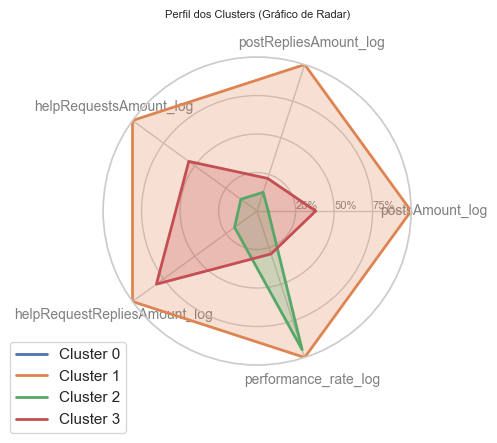

In [33]:
# Passo 1: Unir os dados originais e os clusters
df_analise = train_set_final.copy()
df_analise['Cluster'] = y_kmeans

# Passo 2: Calcular as médias de cada feature para cada cluster
centroids = df_analise.groupby('Cluster').mean()

# Passo 3: Escalonar os centroides para que fiquem na mesma escala (0 a 1) para o plot
scaler_radar = MinMaxScaler()
centroids_scaled = pd.DataFrame(scaler_radar.fit_transform(centroids), index=centroids.index, columns=centroids.columns)

# Passo 4: Código de plotagem do Gráfico de Radar
labels = centroids_scaled.columns
num_vars = len(labels)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))
plt.xticks(angles[:-1], labels, color='grey', size=10)
ax.set_rlabel_position(0)
plt.yticks([0.25, 0.5, 0.75], ["25%", "50%", "75%"], color="grey", size=8)
plt.ylim(0, 1)

# Plotar a linha de cada cluster
for i in range(len(centroids_scaled)):
    values = centroids_scaled.iloc[i].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.25)

plt.title('Perfil dos Clusters (Gráfico de Radar)', size=8, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

--- Regras da Árvore de Decisão ---
|--- performance_rate_log <= 0.16
|   |--- postsAmount_log <= 0.27
|   |   |--- class: 0
|   |--- postsAmount_log >  0.27
|   |   |--- class: 3
|--- performance_rate_log >  0.16
|   |--- performance_rate_log <= 0.50
|   |   |--- postsAmount_log <= 0.78
|   |   |   |--- class: 3
|   |   |--- postsAmount_log >  0.78
|   |   |   |--- class: 1
|   |--- performance_rate_log >  0.50
|   |   |--- postsAmount_log <= 0.27
|   |   |   |--- class: 2
|   |   |--- postsAmount_log >  0.27
|   |   |   |--- class: 1


--- Visualização da Árvore ---


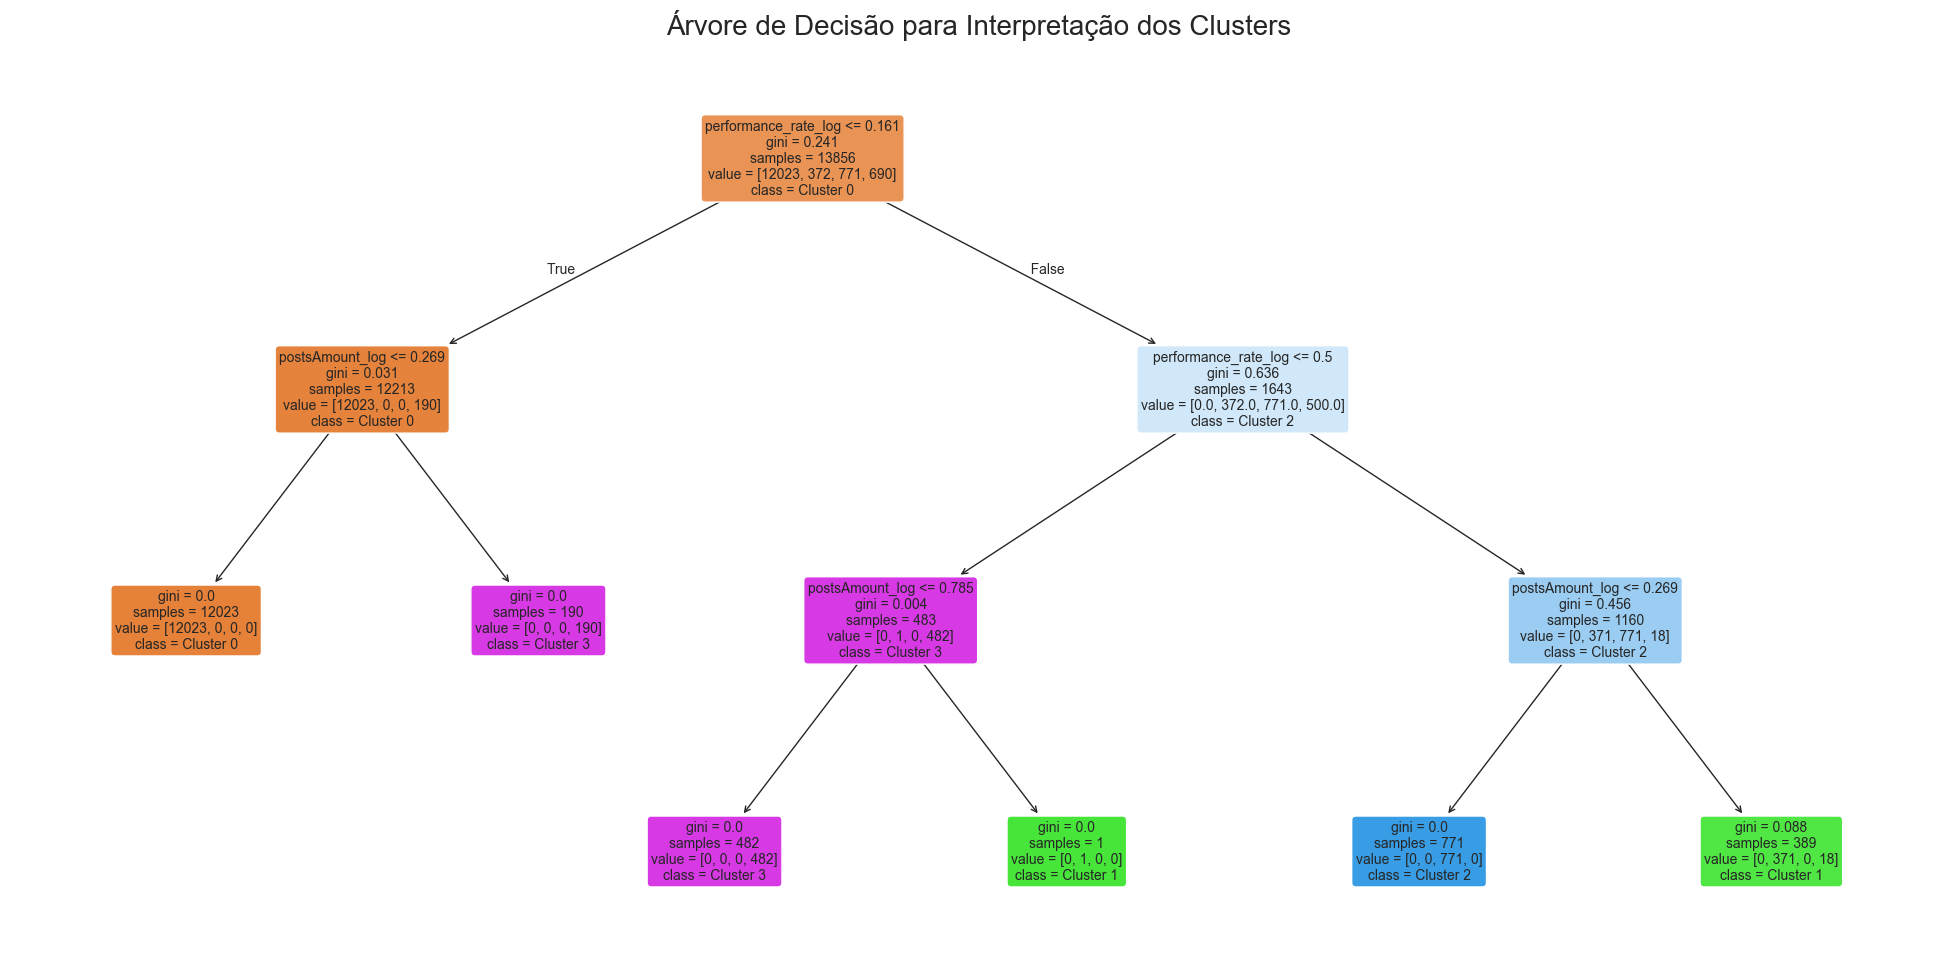

In [34]:
# --- 2. TREINAR A ÁRVORE DE DECISÃO ---

X = train_set_final
y = y_kmeans

# Inicializar o classificador.
arvore_de_decisao = DecisionTreeClassifier(max_depth=3, random_state=42)

# Treinar a árvore para aprender a mapear as features para os clusters
arvore_de_decisao.fit(X, y)


# Extrair as regras como texto 
print("--- Regras da Árvore de Decisão ---")
nomes_features = X.columns.tolist()
regras_texto = export_text(arvore_de_decisao, feature_names=nomes_features)
print(regras_texto)


#  Visualizar a árvore de decisão 
print("\n--- Visualização da Árvore ---")
# Nomes das classes para a legenda do gráfico
nomes_classes = [f'Cluster {i}' for i in sorted(np.unique(y))]

plt.figure(figsize=(25, 12))
plot_tree(
    arvore_de_decisao,
    feature_names=nomes_features,
    class_names=nomes_classes,
    filled=True,  
    rounded=True, 
    fontsize=10
)
plt.title("Árvore de Decisão para Interpretação dos Clusters", fontsize=20)
plt.show()

#### Adicionando Labels aos Clusters

In [35]:

centroids = train_set.groupby('cluster').mean()

print("--- Médias das Variáveis Originais por Cluster ---")
print(centroids)
print("-" * 50)

# Passo 2: Ranquear os centroides para cada métrica
# ascending=False significa que o maior valor recebe o rank 1 (melhor)
centroids['rank_posts'] = centroids['postsAmount'].rank(method='first', ascending=False)
centroids['rank_performance'] = centroids['performance_rate'].rank(method='first', ascending=False)

# Criar scores combinados para facilitar a identificação
# Score Geral: soma dos ranks (quanto menor, melhor)
centroids['score_geral'] = centroids['rank_posts'] + centroids['rank_performance']

print("\n--- Centroides com Ranks e Scores ---")
print(centroids)
print("-" * 50)


# Passo 3: Aplicar as regras de negócio para identificar cada cluster
mapa_de_labels = {}

# "Engajamento excelente": Melhor rank em posts E melhor rank em performance.
# Portanto, terá o menor 'score_geral'.
id_excelente = centroids['score_geral'].idxmin()
mapa_de_labels[id_excelente] = "Engajamento excelente"

# "Não interagem": Pior rank em posts E pior rank em performance.
# Portanto, terá o maior 'score_geral'.
id_nao_interagem = centroids['score_geral'].idxmax()
mapa_de_labels[id_nao_interagem] = "Não interagem"

# Para os dois restantes, analisamos os ranks individuais
indices_restantes = [c for c in centroids.index if c not in mapa_de_labels]

cluster_restante_1 = centroids.loc[indices_restantes[0]]
cluster_restante_2 = centroids.loc[indices_restantes[1]]

# "Engajamento consistente": Rank de performance é MELHOR (menor) que o rank de posts.
# "Desempenho crítico": Rank de posts é MELHOR (menor) que o rank de performance.
if cluster_restante_1['rank_performance'] < cluster_restante_1['rank_posts']:
    mapa_de_labels[indices_restantes[0]] = "Engajamento consistente"
    mapa_de_labels[indices_restantes[1]] = "Desempenho crítico"
else:
    mapa_de_labels[indices_restantes[1]] = "Engajamento consistente"
    mapa_de_labels[indices_restantes[0]] = "Desempenho crítico"


print("\n--- Mapa de Labels Gerado Automaticamente ---")
# Ordena o dicionário pela chave (número do cluster) para facilitar a leitura
mapa_de_labels = dict(sorted(mapa_de_labels.items()))
print(mapa_de_labels)


# Passo 4: Aplicar o mapa gerado para criar a coluna final
train_set['categoria_interacao'] = train_set['cluster'].map(mapa_de_labels)

print("\n--- Contagem final das novas categorias ---")
print(train_set['categoria_interacao'].value_counts())

--- Médias das Variáveis Originais por Cluster ---
         postsAmount  postRepliesAmount  helpRequestsAmount  \
cluster                                                       
0           0.011312           0.001081            0.000166   
1           5.986559           0.543011            0.018817   
2           0.194553           0.053178            0.002594   
3           1.626087           0.100000            0.011594   

         helpRequestRepliesAmount  performance_rate  
cluster                                              
0                        0.000499          0.000000  
1                        0.021505          0.842966  
2                        0.003891          0.786965  
3                        0.021739          0.202053  
--------------------------------------------------

--- Centroides com Ranks e Scores ---
         postsAmount  postRepliesAmount  helpRequestsAmount  \
cluster                                                       
0           0.011312          

In [36]:
print(train_set['categoria_interacao'].value_counts())

categoria_interacao
Não interagem              12023
Engajamento consistente      771
Desempenho crítico           690
Engajamento excelente        372
Name: count, dtype: int64


In [37]:
dataset_clss = train_set.copy()
dataset_clss.head()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,cluster,categoria_interacao
0,0.0,0.0,0.0,0.0,0.0,0,Não interagem
1,0.0,0.0,0.0,0.0,1.0,2,Engajamento consistente
2,0.0,0.0,0.0,0.0,1.0,2,Engajamento consistente
3,0.0,0.0,0.0,0.0,0.0,0,Não interagem
4,0.0,0.0,0.0,0.0,0.0,0,Não interagem


In [38]:
dataset_clss.tail()

,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,cluster,categoria_interacao
13851,0.0,0.0,0.0,0.0,0.0,0,Não interagem
13852,0.0,0.0,0.0,0.0,0.0,0,Não interagem
13853,0.0,0.0,0.0,0.0,0.0,0,Não interagem
13854,0.0,0.0,0.0,0.0,0.0,0,Não interagem
13855,0.0,0.0,0.0,0.0,0.0,0,Não interagem


In [39]:
dataset_clss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   postsAmount               13856 non-null  float64
 1   postRepliesAmount         13856 non-null  float64
 2   helpRequestsAmount        13856 non-null  float64
 3   helpRequestRepliesAmount  13856 non-null  float64
 4   performance_rate          13856 non-null  float64
 5   cluster                   13856 non-null  int32  
 6   categoria_interacao       13856 non-null  object 
dtypes: float64(5), int32(1), object(1)
memory usage: 703.8+ KB


In [40]:
dataframe['categoria_engajamento'] = dataset_clss['categoria_interacao']

In [41]:
dataframe.head()

,cliente,user_id,environment_id,course_id,space_id,subject_id,lecture_id,NivelAgregacao,user_name,environment_name,...,subject_name,lecture_name,period_start_date,period_end_date,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,categoria_engajamento
0,redu-digital,727,73,155,534,<NA>,<NA>,SPA,CARLOS EDUARDO POLONIO DA SILVA,SENAC-PE,...,None,None,2020-04-01,2020-06-30,0,0,0,0,0.0,Não interagem
1,redu-digital,525,73,155,534,<NA>,<NA>,SPA,MERCIA MARIA BARBOSA DE ARAUJO,SENAC-PE,...,None,None,2021-10-01,2021-12-31,0,0,0,0,1.0,Engajamento consistente
2,redu-digital,525,73,155,534,<NA>,<NA>,SPA,MERCIA MARIA BARBOSA DE ARAUJO,SENAC-PE,...,None,None,2021-10-01,2021-12-31,0,0,0,0,1.0,Engajamento consistente
3,redu-digital,525,73,155,534,<NA>,<NA>,SPA,MERCIA MARIA BARBOSA DE ARAUJO,SENAC-PE,...,None,None,2020-04-01,2020-06-30,0,0,0,0,0.0,Não interagem
4,redu-digital,525,73,155,534,<NA>,<NA>,SPA,MERCIA MARIA BARBOSA DE ARAUJO,SENAC-PE,...,None,None,2020-04-01,2020-06-30,0,0,0,0,0.0,Não interagem


In [42]:
dataframe['data_inicio'] = pd.to_datetime(data_inicio).date()
dataframe['data_fim'] = pd.to_datetime(data_fim).date()


# Passo 2: Adicionar a data de hoje como data da classificação
# A função date.today() captura a data atual em que o código é executado.
dataframe['data_classificacao'] = date.today()

In [43]:
dataframe.head()

,cliente,user_id,environment_id,course_id,space_id,subject_id,lecture_id,NivelAgregacao,user_name,environment_name,...,period_end_date,postsAmount,postRepliesAmount,helpRequestsAmount,helpRequestRepliesAmount,performance_rate,categoria_engajamento,data_inicio,data_fim,data_classificacao
0,redu-digital,727,73,155,534,<NA>,<NA>,SPA,CARLOS EDUARDO POLONIO DA SILVA,SENAC-PE,...,2020-06-30,0,0,0,0,0.0,Não interagem,2020-01-01,2021-12-31,2025-09-02
1,redu-digital,525,73,155,534,<NA>,<NA>,SPA,MERCIA MARIA BARBOSA DE ARAUJO,SENAC-PE,...,2021-12-31,0,0,0,0,1.0,Engajamento consistente,2020-01-01,2021-12-31,2025-09-02
2,redu-digital,525,73,155,534,<NA>,<NA>,SPA,MERCIA MARIA BARBOSA DE ARAUJO,SENAC-PE,...,2021-12-31,0,0,0,0,1.0,Engajamento consistente,2020-01-01,2021-12-31,2025-09-02
3,redu-digital,525,73,155,534,<NA>,<NA>,SPA,MERCIA MARIA BARBOSA DE ARAUJO,SENAC-PE,...,2020-06-30,0,0,0,0,0.0,Não interagem,2020-01-01,2021-12-31,2025-09-02
4,redu-digital,525,73,155,534,<NA>,<NA>,SPA,MERCIA MARIA BARBOSA DE ARAUJO,SENAC-PE,...,2020-06-30,0,0,0,0,0.0,Não interagem,2020-01-01,2021-12-31,2025-09-02


In [44]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13856 entries, 0 to 13855
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cliente                   13856 non-null  object 
 1   user_id                   13856 non-null  Int64  
 2   environment_id            13856 non-null  Int64  
 3   course_id                 13856 non-null  Int64  
 4   space_id                  13856 non-null  Int64  
 5   subject_id                0 non-null      Int64  
 6   lecture_id                0 non-null      Int64  
 7   NivelAgregacao            13856 non-null  object 
 8   user_name                 13856 non-null  object 
 9   environment_name          13856 non-null  object 
 10  course_name               13856 non-null  object 
 11  space_name                13856 non-null  object 
 12  subject_name              0 non-null      object 
 13  lecture_name              0 non-null      object 
 14  period

In [45]:
# # Define o nome completo da tabela de destino
# table_id = "viitra-redu.analytics.cubo_engajamento"

# # Prepara o DataFrame para envio
# df_to_load = dataframe.copy()
# df_to_load = df_to_load.rename(columns={
#     'categoria_interacao': 'categoria_engajamento',
#     'data_inicio_consulta': 'data_inicio',
#     'data_fim_consulta': 'data_fim'
# })

# # Converte as colunas de data para o tipo datetime do pandas, a forma mais robusta
# date_columns = ['data_inicio', 'data_fim', 'data_classificacao']
# for col in date_columns:
#     if col in df_to_load.columns:
#         df_to_load[col] = pd.to_datetime(df_to_load[col])

# # Garante que o DataFrame tenha apenas as colunas da tabela de destino
# schema_columns = [
#     'cliente', 'user_id', 'environment_id', 'course_id', 'space_id', 
#     'subject_id', 'lecture_id', 'NivelAgregacao', 'user_name', 
#     'environment_name', 'course_name', 'space_name', 'subject_name', 
#     'lecture_name', 'postsAmount', 'postRepliesAmount', 
#     'helpRequestsAmount', 'helpRequestRepliesAmount', 'performance_rate', 
#     'categoria_engajamento', 'data_inicio', 'data_fim', 'data_classificacao'
# ]
# df_to_load = df_to_load[schema_columns]

# # Configura o job para adicionar os dados (append)
# job_config = bigquery.LoadJobConfig(write_disposition="WRITE_APPEND")

# print(f"Iniciando o carregamento de {len(df_to_load)} registros para a tabela {table_id}...")

# try:
#     # Envia o DataFrame para o BigQuery e aguarda a conclusão
#     load_job = client.load_table_from_dataframe(
#         df_to_load, table_id, job_config=job_config
#     )
#     load_job.result()
#     print("Carregamento concluído com sucesso!")
#     print(f"Foram carregadas {load_job.output_rows} linhas.")

# except Exception as e:
#     print(f"Ocorreu um erro durante o carregamento: {e}")
#     if 'load_job' in locals() and load_job.errors:
#         print("Detalhes do erro do BigQuery:", load_job.errors)

# # Executa uma consulta de verificação no BigQuery
# print("\nVerificação dos dados inseridos hoje no BigQuery:")
# query = f"""
#     SELECT data_classificacao, COUNT(1) as total_registros
#     FROM `{table_id}`
#     WHERE data_classificacao = CURRENT_DATE('America/Sao_Paulo')
#     GROUP BY 1
# """
# results_df = client.query(query).to_dataframe()
# print(results_df)